### BigData & Blockchain Lab
#### BTC-USD Price Prediction as regression problem(Buy/Sell) with Deep LSTM NN.


#### Presented by @SAnbaee

In [1]:
import tensorflow as tf
import pandas as pd
from collections import deque
import random
import numpy as np
from sklearn import preprocessing
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, LSTM, BatchNormalization
from matplotlib import pyplot as plt
import ta
from matplotlib import pyplot as plt

In [2]:

SEQ_LEN = 7 # how long of a preceeding sequence to collect for RNN
FUTURE_PERIOD_PREDICT = 1 # how far into the future are we trying to predict?
RATIO_TO_PREDICT = "BTC-USD"
EPOCHS = 400  # how many passes through our data
BATCH_SIZE = 64



In [3]:
def IndicatorsAddition(df):
  
    df = ta.utils.dropna(df)
    # Initialize Bollinger Bands Indicator
    indicator_bb = ta.volatility.BollingerBands(close=df["Close"], n=20, ndev=2)
    '''
    set 1 :
    Stochastic %K, Stochastic %D, Momentum, Rate of change,
    William’s %R, Accumulation/Distribution (A/D)
    
    set 2
    EMA, MACD, RSI, On Balance Volume, Bollinger Bands
    
    '''
    df['stochastic'] = ta.momentum.StochasticOscillator(high = df['High'], low = df['Low'],
                                                        close = df['Close'], n = 14, d_n = 3,
                                                        fillna = False).stoch()
    
    df['momentum'] = ta.momentum.AwesomeOscillatorIndicator(high = df['High'], low = df['Low'], 
                                                            s = 5, len = 34, fillna= False) .ao()
    
    df['wiliams'] = ta.momentum.WilliamsRIndicator(high = df['High'], low = df['Low'], 
                                                   close = df['Close'], lbp = 14, fillna = False).wr()
    
    df ['ADI'] = ta.volume.AccDistIndexIndicator(high = df['High'], low = df['Low'], close = df['Close']
                                                 , volume = df['Volume'], fillna = False).acc_dist_index()
    
    
    df['EMA'] = ta.trend.EMAIndicator(close = df['Close'], n = 14, fillna = False).ema_indicator()
    
    
    df['MACD'] = ta.trend.MACD(close = df['Close'], n_slow = 26, n_fast = 12,
                               n_sign = 9, fillna = False).macd()
    
    df['RSI'] = ta.momentum.RSIIndicator(close = df['Close'], n = 14, fillna = False).rsi()
    
    df['on_balance_volume'] = ta.volume.OnBalanceVolumeIndicator(close = df['Close'], volume = df['Volume'],
                                                                 fillna = False).on_balance_volume()
    df['bb_bbm'] = indicator_bb.bollinger_mavg()
    
    return df
    


In [4]:
def normalization(df):
    #df = df.drop("future", 1)  # don't need this anymore.
    df = df.drop("High", 1)  # don't need this anymore.
    df = df.drop("Low", 1)  # don't need this anymore.
    df = df.drop("Open", 1)  # don't need this anymore.
    
    for col in df.columns:  # go through all of the columns
        if col != "target":  # normalize all ... except for the target itself!
            df[col] =[float(e) for e in df[col]]
            df[col] = df[col].pct_change()  # pct changefor  "normalizes"
            df = df.replace([np.inf, -np.inf], None)
            df.dropna(inplace=True )  # remove the nas created by pct_change
            df[col] = preprocessing.scale(df[col].values)  # scale between 0 and 1.
    
    df.dropna(inplace=True)  # cleanup again... jic.
    return df


In [5]:
def preprocess_df(df):
    
    df  = normalization(df)
    date = df.index.values[SEQ_LEN-1:]
    sequential_data = []  # this is a list that will CONTAIN the sequences
    
    # These will be our actual sequences. 
    #they are made with deque, which keeps
    #the maximum length by popping out older 
    #values as new ones come in
    prev_days = deque(maxlen=SEQ_LEN)  

    for i in df.values:  # iterate over the values
    
        prev_days.append([n for n in i[:-1]])  # store all but the target
        if len(prev_days) == SEQ_LEN:  # make sure we have 10 sequences!
            sequential_data.append([np.array(prev_days), i[-1]])  # i[-1] is the sequence target
            

    
    random.shuffle(sequential_data)  # shuffle for good measure.
    
    X = []
    y = []

    for seq, target in sequential_data:  # going over our new sequential data
        X.append(seq)  # X is the sequences
        y.append(target)  # y is the targets/labels (buys vs sell/notbuy)

    return list(date) , np.array(X), y  # return X and y...and make X a numpy array!


In [6]:
import requests
from datetime import datetime 
import pandas as pd

startDate = datetime(2019,10,1).timestamp()
startDate = int(startDate)
print(startDate)
endDate = datetime.now().timestamp()
endDate = int(endDate)

print(endDate)
queryString = 'https://finnhub.io/api/v1/crypto/candle?symbol=BINANCE:BTCUSDT&resolution=D&from='
queryString += str(startDate ) + '&to=' + str(endDate)+ '&token='

columns={'Close','High','Low','Open','Status','timestamp','Volume'}
r = requests.get(queryString)

df = pd.DataFrame(r.json())

df['Close'] = df['c']
df = df.drop('c',1)

df['Open'] = df['o']
df = df.drop('o',1)

df['Low'] = df['l']
df = df.drop('l',1)

df['High'] = df['h']
df = df.drop('h',1)

df = df.drop('s',1)


df['timestamp'] = df['t']
df = df.drop('t',1)

df['Volume'] = df['v']
df = df.drop('v',1)

df['Date'] = [datetime.utcfromtimestamp(ts).strftime('%Y-%m-%d') for ts in df['timestamp']]
df = df.drop('timestamp',1)



1569875400
1603952998


In [7]:

print(df.head())
print(df.describe())
print(df.Date[:1])
print(df.Date[-1:])

     Close     Open      Low     High        Volume        Date
0  8292.44  8289.97  8173.05  8500.00  43472.418091  2019-10-01
1  8359.94  8292.67  8151.22  8373.91  26243.386644  2019-10-02
2  8223.96  8360.00  8060.00  8393.00  30488.284058  2019-10-03
3  8137.13  8224.43  8005.00  8232.41  26476.330404  2019-10-04
4  8126.19  8137.09  8012.98  8183.41  21907.615564  2019-10-05
              Close          Open           Low          High         Volume
count    395.000000    395.000000    395.000000    395.000000     395.000000
mean    9093.574987   9080.885823   8868.016354   9281.435367   62240.751747
std     1658.441911   1645.467809   1657.884512   1640.053504   38831.968618
min     4800.000000   4800.010000   3782.130000   5365.420000   13758.632296
25%     7874.405000   7874.935000   7645.565000   8106.550000   39127.463002
50%     9170.000000   9162.210000   9021.000000   9298.000000   53308.175266
75%    10158.230000  10145.005000   9813.000000  10358.570000   71746.402118


In [8]:
main_df = df
main_df['timestamp'] = main_df['Date'] #+' '+ main_df['time']

main_df['timestamp'] = pd.to_datetime(main_df['timestamp'])
main_df = main_df.sort_values('timestamp', axis = 0  )
main_df = main_df.set_index('timestamp')
main_df = main_df.drop('Date' ,1)


main_df.fillna(method="ffill", inplace=True)  # if there are gaps in data, use previously known values
main_df.dropna(inplace=True)

# add indicators 
main_df = IndicatorsAddition(main_df) 


# add target 
main_df['target'] = main_df['Close'].shift(-FUTURE_PERIOD_PREDICT)
#target = main_df['Close'].shift(-FUTURE_PERIOD_PREDICT)
#target = np.array(target)
#target = target.reshape(-1,1)
#scale target between 0 to 1
#min_max_scaler = preprocessing.MinMaxScaler()
#main_df['scaled target']= min_max_scaler.fit_transform(target)

 


#test and train seprate
dates = sorted(main_df.index.values)  # get the dates
last_5pct = sorted(main_df.index.values)[-int(0.2*len(dates))]  # get the last 20% of the times

test_main_df = main_df[(main_df.index >= last_5pct)]  # make the validation data where the index is in the last 5%
main_df = main_df[(main_df.index < last_5pct)]  # now the main_df is all the data up to the last 5%




dates = sorted(main_df.index.values)  # get the dates
last_5pct = sorted(main_df.index.values)[-int(0.25*len(dates))]  # get the last 20% of the times
validation_main_df =  main_df[(main_df.index > last_5pct)]  
main_df = main_df[(main_df.index < last_5pct)] 

print(main_df.shape)
print(validation_main_df.shape)
print(test_main_df.shape)

print(main_df.head())
print(main_df.describe())


(237, 15)
(78, 15)
(79, 15)
              Close     Open      Low     High        Volume  stochastic  \
timestamp                                                                  
2019-10-01  8292.44  8289.97  8173.05  8500.00  43472.418091         NaN   
2019-10-02  8359.94  8292.67  8151.22  8373.91  26243.386644         NaN   
2019-10-03  8223.96  8360.00  8060.00  8393.00  30488.284058         NaN   
2019-10-04  8137.13  8224.43  8005.00  8232.41  26476.330404         NaN   
2019-10-05  8126.19  8137.09  8012.98  8183.41  21907.615564         NaN   

            momentum  wiliams           ADI  EMA  MACD  RSI  \
timestamp                                                     
2019-10-01       NaN      NaN -11723.392271  NaN   NaN  NaN   
2019-10-02       NaN      NaN  11227.344398  NaN   NaN  NaN   
2019-10-03       NaN      NaN  10762.237843  NaN   NaN  NaN   
2019-10-04       NaN      NaN  15052.518725  NaN   NaN  NaN   
2019-10-05       NaN      NaN  22249.651832  NaN   NaN  NaN  

In [10]:
d1 , train_x, train_y = preprocess_df(main_df)
d2 , validation_x, validation_y = preprocess_df(validation_main_df)
d3 , test_x, test_y = preprocess_df(test_main_df)

print(train_x.shape)
print(f"train data: {len(train_x)} ")
print(f"validation data: {len(validation_x)}")
print(f"test Data: {len(test_x)}")




(188, 7, 11)
train data: 188 
validation data: 61
test Data: 61


In [11]:
EPOCHS = 500  # how many passes through our data
BATCH_SIZE = 64  # how many batches? Try smaller batch if you're getting OOM (out of memory) errors.


In [12]:
model = Sequential()
model.add(LSTM(128, input_shape=(train_x.shape[1:]), return_sequences=True))
model.add(Dropout(0.2))
model.add(BatchNormalization())  #normalizes activation outputs, same reason you want to normalize your input data.


model.add(LSTM(128))
model.add(Dropout(0.2))
model.add(BatchNormalization())

model.add(Dense(32, activation='relu'))
model.add(Dropout(0.2))


model.add(Dense(1))



In [13]:
opt = tf.keras.optimizers.Adam(lr=0.001, decay=1e-6)

# Compile model
model.compile(
    loss=tf.keras.losses.MeanAbsolutePercentageError(),
    optimizer=opt,
   
)
model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 7, 128)            71680     
_________________________________________________________________
dropout (Dropout)            (None, 7, 128)            0         
_________________________________________________________________
batch_normalization (BatchNo (None, 7, 128)            512       
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 128)               512       
_________________________________________________________________
dense (Dense)                (None, 32)                4

In [14]:
history = model.fit(
    train_x, np.array(train_y),
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
     validation_data=(validation_x, np.array(validation_y)),
    )


Train on 188 samples, validate on 61 samples
Epoch 1/500
188/188 [==============================] - 8s 44ms/sample - loss: 99.9946 - val_loss: 99.9988
Epoch 2/500
188/188 [==============================] - 0s 781us/sample - loss: 99.9744 - val_loss: 99.9975
Epoch 3/500
188/188 [==============================] - 0s 787us/sample - loss: 99.9603 - val_loss: 99.9958
Epoch 4/500
188/188 [==============================] - 0s 771us/sample - loss: 99.9502 - val_loss: 99.9936
Epoch 5/500
188/188 [==============================] - 0s 808us/sample - loss: 99.9346 - val_loss: 99.9910
Epoch 6/500
188/188 [==============================] - 0s 787us/sample - loss: 99.9260 - val_loss: 99.9878
Epoch 7/500
188/188 [==============================] - 0s 781us/sample - loss: 99.9174 - val_loss: 99.9842
Epoch 8/500
188/188 [==============================] - 0s 765us/sample - loss: 99.9090 - val_loss: 99.9799
Epoch 9/500
188/188 [==============================] - 0s 803us/sample - loss: 99.8947 - val_loss: 9

188/188 [==============================] - 0s 813us/sample - loss: 97.7503 - val_loss: 97.8672
Epoch 70/500
188/188 [==============================] - 0s 787us/sample - loss: 97.5689 - val_loss: 97.8100
Epoch 71/500
188/188 [==============================] - 0s 755us/sample - loss: 97.5454 - val_loss: 97.7386
Epoch 72/500
188/188 [==============================] - 0s 765us/sample - loss: 97.4758 - val_loss: 97.7296
Epoch 73/500
188/188 [==============================] - 0s 755us/sample - loss: 97.3636 - val_loss: 97.6547
Epoch 74/500
188/188 [==============================] - 0s 734us/sample - loss: 97.3607 - val_loss: 97.5907
Epoch 75/500
188/188 [==============================] - 0s 750us/sample - loss: 97.2121 - val_loss: 97.5346
Epoch 76/500
188/188 [==============================] - 0s 760us/sample - loss: 97.1493 - val_loss: 97.5103
Epoch 77/500
188/188 [==============================] - 0s 765us/sample - loss: 96.9959 - val_loss: 97.5492
Epoch 78/500
188/188 [===================

188/188 [==============================] - 0s 829us/sample - loss: 84.5172 - val_loss: 87.2162
Epoch 145/500
188/188 [==============================] - 0s 803us/sample - loss: 84.0574 - val_loss: 86.5668
Epoch 146/500
188/188 [==============================] - 0s 866us/sample - loss: 83.8591 - val_loss: 86.1233
Epoch 147/500
188/188 [==============================] - 0s 1ms/sample - loss: 83.7841 - val_loss: 85.7677
Epoch 148/500
188/188 [==============================] - 0s 952us/sample - loss: 83.2495 - val_loss: 85.6321
Epoch 149/500
188/188 [==============================] - 0s 1ms/sample - loss: 82.8579 - val_loss: 85.2729
Epoch 150/500
188/188 [==============================] - 0s 1ms/sample - loss: 82.7961 - val_loss: 84.9960
Epoch 151/500
188/188 [==============================] - 0s 936us/sample - loss: 82.4925 - val_loss: 84.7756
Epoch 152/500
188/188 [==============================] - 0s 813us/sample - loss: 81.4932 - val_loss: 84.4600
Epoch 153/500
188/188 [================

188/188 [==============================] - 0s 888us/sample - loss: 49.5434 - val_loss: 48.0035
Epoch 220/500
188/188 [==============================] - 0s 787us/sample - loss: 49.2923 - val_loss: 47.4330
Epoch 221/500
188/188 [==============================] - 0s 813us/sample - loss: 49.5806 - val_loss: 47.7163
Epoch 222/500
188/188 [==============================] - 0s 755us/sample - loss: 48.7734 - val_loss: 47.3502
Epoch 223/500
188/188 [==============================] - 0s 750us/sample - loss: 45.6617 - val_loss: 47.3149
Epoch 224/500
188/188 [==============================] - 0s 771us/sample - loss: 46.4538 - val_loss: 47.5295
Epoch 225/500
188/188 [==============================] - 0s 739us/sample - loss: 45.2707 - val_loss: 47.2186
Epoch 226/500
188/188 [==============================] - 0s 771us/sample - loss: 44.8829 - val_loss: 46.7650
Epoch 227/500
188/188 [==============================] - 0s 781us/sample - loss: 44.2963 - val_loss: 46.4178
Epoch 228/500
188/188 [==========

188/188 [==============================] - 0s 845us/sample - loss: 19.0837 - val_loss: 26.1736
Epoch 295/500
188/188 [==============================] - 0s 936us/sample - loss: 18.0133 - val_loss: 26.3486
Epoch 296/500
188/188 [==============================] - 0s 856us/sample - loss: 19.1878 - val_loss: 27.0935
Epoch 297/500
188/188 [==============================] - 0s 898us/sample - loss: 20.1828 - val_loss: 26.5607
Epoch 298/500
188/188 [==============================] - 0s 797us/sample - loss: 19.0802 - val_loss: 27.1734
Epoch 299/500
188/188 [==============================] - 0s 819us/sample - loss: 20.5853 - val_loss: 26.7552
Epoch 300/500
188/188 [==============================] - 0s 893us/sample - loss: 19.0827 - val_loss: 25.9693
Epoch 301/500
188/188 [==============================] - 0s 978us/sample - loss: 18.2061 - val_loss: 25.3306
Epoch 302/500
188/188 [==============================] - 0s 872us/sample - loss: 19.7155 - val_loss: 24.7376
Epoch 303/500
188/188 [==========

188/188 [==============================] - 0s 792us/sample - loss: 13.8733 - val_loss: 25.4131
Epoch 370/500
188/188 [==============================] - 0s 787us/sample - loss: 15.0142 - val_loss: 25.2808
Epoch 371/500
188/188 [==============================] - 0s 781us/sample - loss: 16.4931 - val_loss: 25.1443
Epoch 372/500
188/188 [==============================] - 0s 755us/sample - loss: 17.1709 - val_loss: 24.7229
Epoch 373/500
188/188 [==============================] - 0s 776us/sample - loss: 17.6078 - val_loss: 24.4314
Epoch 374/500
188/188 [==============================] - 0s 765us/sample - loss: 15.4683 - val_loss: 24.3097
Epoch 375/500
188/188 [==============================] - 0s 771us/sample - loss: 15.0153 - val_loss: 24.0668
Epoch 376/500
188/188 [==============================] - 0s 750us/sample - loss: 16.5333 - val_loss: 23.9534
Epoch 377/500
188/188 [==============================] - 0s 776us/sample - loss: 16.8022 - val_loss: 23.9401
Epoch 378/500
188/188 [==========

188/188 [==============================] - 0s 835us/sample - loss: 15.4209 - val_loss: 23.3202
Epoch 445/500
188/188 [==============================] - 0s 797us/sample - loss: 19.3750 - val_loss: 23.1555
Epoch 446/500
188/188 [==============================] - 0s 813us/sample - loss: 16.7961 - val_loss: 22.9280
Epoch 447/500
188/188 [==============================] - 0s 803us/sample - loss: 17.3430 - val_loss: 22.7493
Epoch 448/500
188/188 [==============================] - 0s 808us/sample - loss: 15.3858 - val_loss: 22.4148
Epoch 449/500
188/188 [==============================] - 0s 973us/sample - loss: 18.1966 - val_loss: 22.2796
Epoch 450/500
188/188 [==============================] - 0s 835us/sample - loss: 18.0970 - val_loss: 21.8591
Epoch 451/500
188/188 [==============================] - 0s 765us/sample - loss: 17.8681 - val_loss: 21.2062
Epoch 452/500
188/188 [==============================] - 0s 765us/sample - loss: 16.5096 - val_loss: 20.1142
Epoch 453/500
188/188 [==========

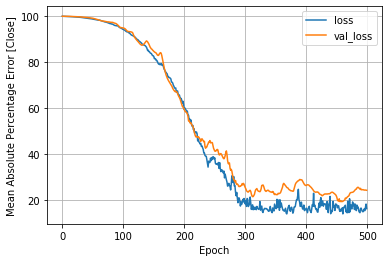

In [15]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  #plt.ylim([0, 10])
  plt.xlabel('Epoch')
  plt.ylabel('Mean Absolute Percentage Error [Close]')
  plt.legend()
  plt.grid(True)


plot_loss(history)

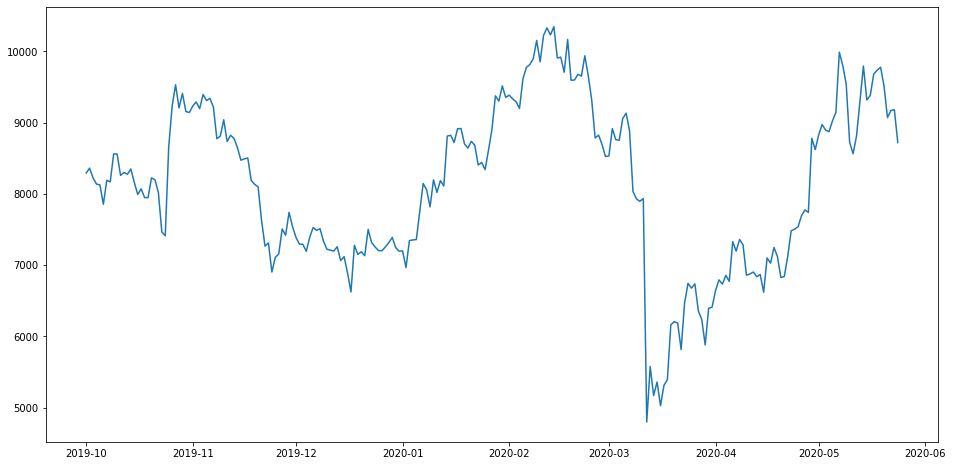

In [16]:

plt.figure(figsize=(16,8))
plt.plot(main_df["Close"],label='Close Price history')


No handles with labels found to put in legend.


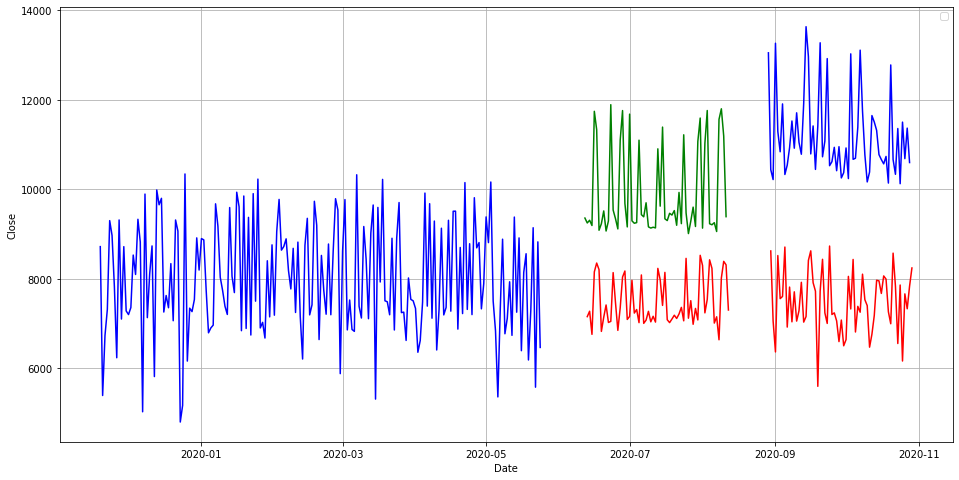

In [17]:
predict_y = model.predict(test_x)
predict_validation_y = model.predict(validation_x)

def plot_prediction():
  
  plt.figure(figsize=(16,8))
  d2predict = [w +   np.timedelta64(1, 'D')  for w in d2]
  d3predict = [w  + np.timedelta64(1, 'D')  for w in d3]
  
  
  plt.plot(d1,train_y , color = 'blue')
  plt.plot(d2predict,predict_validation_y , color = 'red')
  plt.plot(d2,validation_y ,color = 'green')
  plt.plot(d3predict,predict_y , color = 'red')
  plt.plot(d3,test_y , color = 'blue')
  
  
  #plt.ylim([0, 10])
  plt.xlabel('Date')
  plt.ylabel('Close')
  plt.savefig('BTC-USD predict.jpg')
  plt.legend()
  plt.grid(True)

plot_prediction()